In [18]:
%matplotlib inline
import os, sys, gc
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML
from numpy import array
from soft_knn import SoftKNN, softmax

load_dir = 'lo-shot-dinos-classification-genetic-pilot'
print(os.listdir(load_dir))

['participants.csv', 'new-html-button-response.csv', 'survey-multi-choice.csv', 'html-button-response.csv']


In [19]:
sl =[[array([0., 0., 1.]), array([0.25, 0.25, 0.5 ])],#0
 [array([0., 0., 1.]), array([0.25, 0.5 , 0.25])],#1
 [array([0., 0., 1.]), array([0.25, 0.75, 0.  ])],#2
 [array([0., 0., 1.]), array([0.5, 0.5, 0. ])],#3
 [array([0.  , 0.25, 0.75]), array([0.25, 0.  , 0.75])],#4
 [array([0.  , 0.25, 0.75]), array([0.25, 0.25, 0.5 ])],#5
 [array([0.  , 0.25, 0.75]), array([0.25, 0.5 , 0.25])],#6
 [array([0.  , 0.25, 0.75]), array([0.25, 0.75, 0.  ])],#7
 [array([0.  , 0.25, 0.75]), array([0.5, 0. , 0.5])],#8
 [array([0.  , 0.25, 0.75]), array([0.5 , 0.25, 0.25])],#9
 [array([0.  , 0.25, 0.75]), array([0.5, 0.5, 0. ])],#10
 [array([0.  , 0.25, 0.75]), array([0.75, 0.25, 0.  ])],#11
 [array([0. , 0.5, 0.5]), array([0.25, 0.25, 0.5 ])],#12
 [array([0. , 0.5, 0.5]), array([0.5, 0. , 0.5])],#13
 [array([0. , 0.5, 0.5]), array([0.5 , 0.25, 0.25])],#14
 [array([0.25, 0.25, 0.5 ]), array([0.25, 0.25, 0.5 ])],#15
 [array([0.25, 0.25, 0.5 ]), array([0.25, 0.5 , 0.25])]]#16

peaks_dict={}
peaks_dict[1]=[26.80555556, 13.78021978,  4.6043956 ]
peaks_dict[2]=[26.74,       13.88505747,  4.31818182]
peaks_dict[4]=[ 41.,  -22.,    9.5]
peaks_dict[5]=[29.16666667, 29.875,       8.55194805]
peaks_dict[6]=[27.40909091, 13.43434343,  4.64444444]
peaks_dict[7]=[26.90909091, 14.30434783,  4.56701031]
peaks_dict[8]=[15.33333333, -2.66666667,  5.34579439]
peaks_dict[9]= [12.96842105,  8.56521739,  5.58536585]
peaks_dict[10]= [20.,   21.,    0.99]
peaks_dict[11]= [10.73863636,  9.56666667,  7.81707317]
peaks_dict[12]= [21.23529412,  5.98913043, 21.14864865]
peaks_dict[13]= [12.12162162,  5.72988506,  9.50769231]
peaks_dict[14]= [13.4875,      6.87179487,  6.78571429]
peaks_dict[16]= [38.,         13.74038462,  4.48387097]


In [20]:
def np_peaks(lab1,lab2):
    diffs = lab2-lab1    
    shift=(1-lab2)/diffs
    shift[diffs==0]=-0.5
    return 14+(shift*(14-5))

# def optim_peaks(lab1,lab2):
#     p1=cp.Variable()
#     p2=cp.Variable()
#     p3=cp.Variable()
#     e1=5
#     e2=14
#     denom1=(p1-e1)**-2 +(p2-e1)**-2 + (p3-e1)**-2
#     pred1 = np.array([((p1-e1)**-2)/denom1,((p2-e1)**-2)/denom1,((p3-e1)**-2)/denom1])
#     print(pred1)
#     denom2=(p1-e2)**-2 +(p2-e2)**-2 + (p3-e2)**-2
#     pred2 = np.array([((p1-e2)**-2)/denom2,((p2-e2)**-2)/denom2,((p3-e2)**-2)/denom2])
#     cost=0
#     for i in range(len(lab1)):
#         cost+=cp.sum_squares(pred1[i]-lab1[i])+cp.sum_squares(pred2[i]-lab2[i])
#     prob = cp.Problem(cp.Minimize(cost))
#     prob.solve()
#     print("\nThe optimal value is", prob.value)
#     print("The optimal x is")
#     print(p1.value,p2.value,p3.value)
#     return p1.value, p2.value, p3.value

import torch
from torch.autograd import Variable
dtype = torch.FloatTensor

def optim_peaks(lab1,lab2, verbose=False):
    inits=np_peaks(lab1,lab2)+0.001
    lab1=torch.tensor(lab1, requires_grad=False)
    lab2=torch.tensor(lab2, requires_grad=False)
    p1=torch.tensor([inits[0]],requires_grad=True)
    p2=torch.tensor([inits[1]],requires_grad=True)
    p3=torch.tensor([inits[2]],requires_grad=True)
    e1=5
    e2=14
    cost=0    
    learning_rate = .3
    for t in range(10001):
        denom1=(p1-e1)**-2 +(p2-e1)**-2 + (p3-e1)**-2
        pred1 = torch.cat([((p1-e1)**-2)/denom1,((p2-e1)**-2)/denom1,((p3-e1)**-2)/denom1])
        denom2=(p1-e2)**-2 +(p2-e2)**-2 + (p3-e2)**-2
        pred2 = torch.cat([((p1-e2)**-2)/denom2,((p2-e2)**-2)/denom2,((p3-e2)**-2)/denom2])
        # Forward pass: compute predicted y using operations on Variables; these
        # are exactly the same operations we used to compute the forward pass using
        # Tensors, but we do not need to keep references to intermediate values since
        # we are not implementing the backward pass by hand.
        # Compute and print loss using operations on Variables.
        # Now loss is a Variable of shape (1,) and loss.data is a Tensor of shape
        # (1,); loss.data[0] is a scalar value holding the loss.
        loss = torch.nn.functional.kl_div(pred1.log(),lab1) + torch.nn.functional.kl_div(pred2.log(),lab2)
        #(pred1 - lab1).pow(2).sum() + (pred2 - lab2).pow(2).sum()
        if verbose and not t%1000:
            print(t, loss)
            print(pred1,pred2)
            print(lab1,lab2)
            prototype_loc = [p1.detach().numpy(), p2.detach().numpy(),p3.detach().numpy()]
            prototype_lab = np.array([np.array([1., 0., 0.]), np.array([0.,1.,0.]), np.array([0.,0.,1.])])
            clf.fit(prototype_loc, prototype_lab)
            x=np.linspace(0,19, 20)
            preds=clf.probabilities(x)
            plt.plot(x,preds)
            plt.show()
            

        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Variables with requires_grad=True.
        # After this call w1.grad and w2.grad will be Variables holding the gradient
        # of the loss with respect to w1 and w2 respectively.
        loss.backward()
        

        # Update weights using gradient descent; w1.data and w2.data are Tensors,
        # w1.grad and w2.grad are Variables and w1.grad.data and w2.grad.data are
        # Tensors.
        p1.data -= learning_rate * p1.grad.data
        p2.data -= learning_rate * p2.grad.data
        p3.data -= learning_rate * p3.grad.data
        # Manually zero the gradients after updating weights
        p1.grad.data.zero_()
        p2.grad.data.zero_()
        p3.grad.data.zero_()
    print("\nThe optimal value is", loss)
    print("The optimal x is")
    print(p1.detach().numpy(), p2.detach().numpy(),p3.detach().numpy())
    return p1.detach().numpy(), p2.detach().numpy(),p3.detach().numpy()

optim_peaks(*sl[1])

/home/is2961/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:2886: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



The optimal value is tensor(0.0182, dtype=torch.float64, grad_fn=<AddBackward0>)
The optimal x is
[30.03313363] [23.70216929] [2.68880855]


(array([30.03313363]), array([23.70216929]), array([2.68880855]))

## Probabilties

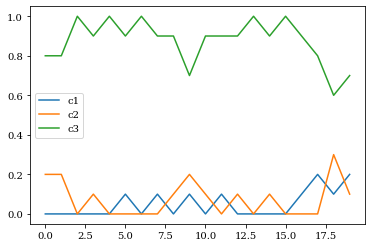

[13.8         9.33333333  9.26857143]
[ 41.  -22.    9.5]


/tmp/ipykernel_39597/3064832552.py:38: RuntimeWarning: divide by zero encountered in divide
  shift=(1-lab2)/diffs


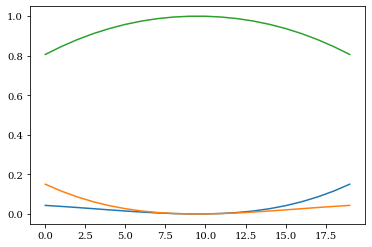

[ 41.  -22.    9.5]


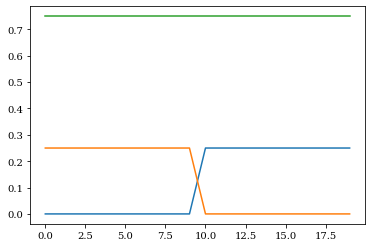

[ 41.  -22.    9.5]


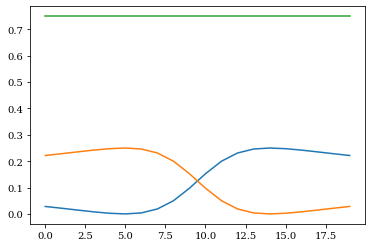

[ 41.  -22.    9.5]


In [21]:
i=0
for num in [4]:
    i+=1
    ignore = ['w93e05c8', 'w8f3a5e6', 'w72ff099', 'w6189e36', 'w3cbe79c',
           'w86d39ac', 'wfc8e96c', 'wf2fae6e', 'w2c152d2', 'wbfb9c6f',]
           #'wcfe7234', 'wb38724c', 'we815cde', 'wb2873cd', 'wf369503']
    button_response_data = pd.read_csv("{}/html-button-response.csv".format(load_dir))
    responses = button_response_data[(button_response_data.task == 'testing_c1_categorize') | (button_response_data.task == 'testing_c2_categorize')]
    responses = responses[["wid", "task", "response", "target_dino", "label_pair", "manifold_jitter"]]
    for wid in ignore:
        responses = responses[responses.wid != wid]
    responses = responses[responses.label_pair == num]

    responses["response"] = responses["response"].astype('category',copy=False)
    responses["target_dino"] = responses["target_dino"].astype('category',copy=False)

    cloud=responses
    cloud_dict={}
    for i in range(20):
        cloud_dict[i]=[0, 0, 0]
    for i in range(len(cloud.target_dino)):
        cloud_dict[int(list(cloud.target_dino)[i])][list(cloud.response)[i]]+=1
    class1 = [cloud_dict[i][0]/sum(cloud_dict[i]) for i in range(20)]
    class2 = [cloud_dict[i][1]/sum(cloud_dict[i]) for i in range(20)]
    class3 = [cloud_dict[i][2]/sum(cloud_dict[i]) for i in range(20)]
    plt.plot(list(range(20)),class1, label='c1')
    plt.plot(list(range(20)),class2, label='c2')
    plt.plot(list(range(20)),class3, label='c3')
    plt.legend()
    plt.show()
    mp1=np.sum(class1*np.array(range(20)))/np.sum(class1)
    mp2=np.sum(class2*np.array(range(20)))/np.sum(class2)
    mp3=np.sum(class3*np.array(range(20)))/np.sum(class3)
    mean_peaks=np.array([mp1,mp2,mp3])

    def peaks(lab1, lab2):
        diffs = lab2-lab1
        shift=(1-lab2)/diffs
        shift[diffs==0]=-0.5
        return 14+(shift*(14-5))
    shift_peaks=peaks(*sl[num])
    print(mean_peaks)
    print(shift_peaks)

    clf=SoftKNN(k=3)
    prototype_loc = shift_peaks#mean_peaks+[20,0,0]#+[-3,-11,-1.01]#+[41/2 - mean_peaks[0]/2,0,0]#mean_peaks+[41/2 - mean_peaks[0]/2,-41/2 + mean_peaks[1]/2,0]#np.array([18,13.7,4.6])
    prototype_lab = np.array([np.array([1., 0., 0.]), np.array([0.,1.,0.]), np.array([0.,0.,1.])])
    clf.fit(prototype_loc, prototype_lab)
    x=np.linspace(0,19, 20)
    preds=clf.probabilities(x)
    plt.plot(x,preds)
    plt.show()
    print(prototype_loc)

    clf2=SoftKNN(k=1)
    clf2.fit([5.0001,14.0001],sl[num])
    x=np.linspace(0,19, 20)
    preds=clf2.probabilities(x)
    plt.plot(x,preds)
    plt.show()
    print(prototype_loc)

    clf2=SoftKNN(k=2)
    clf2.fit([5.0001,14.0001],sl[num])
    x=np.linspace(0,19, 20)
    preds=clf2.probabilities(x)
    plt.plot(x,preds)
    plt.show()
    print(prototype_loc)

[[2.58555343e-02 9.78342351e-02 8.76310231e-01]
 [1.77509322e-02 7.23720620e-02 9.09877006e-01]
 [1.04004184e-02 4.61149711e-02 9.43484611e-01]
 [4.42411237e-03 2.15738454e-02 9.74002042e-01]
 [6.99201119e-04 3.80177315e-03 9.95499026e-01]
 [3.28370796e-04 2.02529394e-03 9.97646335e-01]
 [4.34033157e-03 3.10382918e-02 9.64621377e-01]
 [1.28396834e-02 1.09557176e-01 8.77603141e-01]
 [2.36649726e-02 2.50489565e-01 7.25845463e-01]
 [3.19661172e-02 4.43511837e-01 5.24522045e-01]
 [3.28244919e-02 6.48738481e-01 3.18437027e-01]
 [2.53635550e-02 8.19731076e-01 1.54905369e-01]
 [1.34815807e-02 9.32487434e-01 5.40309854e-02]
 [3.15659209e-03 9.88308039e-01 8.53536912e-03]
 [2.94316729e-04 9.99158967e-01 5.46716716e-04]
 [1.04208316e-02 9.76139896e-01 1.34392721e-02]
 [3.90700081e-02 9.25801219e-01 3.51287725e-02]
 [9.17406562e-02 8.50851553e-01 5.74077911e-02]
 [1.72814241e-01 7.52511929e-01 7.46738299e-02]
 [2.83273116e-01 6.33444492e-01 8.32823923e-02]]
[[4.32915814e-02 1.50357744e-01 8.06350

/tmp/ipykernel_39597/4204100644.py:51: RuntimeWarning: divide by zero encountered in divide
  shift=(1-lab2)/diffs
/tmp/ipykernel_39597/4204100644.py:51: RuntimeWarning: divide by zero encountered in divide
  shift=(1-lab2)/diffs


[[1.13597625e-01 4.37614590e-01 4.48787784e-01]
 [9.82200346e-02 4.44231484e-01 4.57548481e-01]
 [8.11571779e-02 4.51232111e-01 4.67610711e-01]
 [6.24551859e-02 4.58234489e-01 4.79310325e-01]
 [4.25286052e-02 4.64170875e-01 4.93300520e-01]
 [2.26490543e-02 4.65685958e-01 5.11664988e-01]
 [6.03951037e-03 4.45499051e-01 5.48461438e-01]
 [2.87505974e-04 7.36191516e-01 2.63520978e-01]
 [2.21827140e-02 5.24792484e-01 4.53024802e-01]
 [1.04676005e-01 4.65402907e-01 4.29921088e-01]
 [2.92386534e-01 3.63408727e-01 3.44204739e-01]
 [5.84289223e-01 2.12144373e-01 2.03566404e-01]
 [8.57987980e-01 7.21878945e-02 6.98241254e-02]
 [9.87671521e-01 6.25021826e-03 6.07826091e-03]
 [9.89887435e-01 5.11697356e-03 4.99559101e-03]
 [9.35865206e-01 3.24052038e-02 3.17295899e-02]
 [8.69480854e-01 6.58720807e-02 6.46470654e-02]
 [8.07410675e-01 9.71096023e-02 9.54797228e-02]
 [7.53950104e-01 1.23972909e-01 1.22076987e-01]
 [7.09082322e-01 1.46487577e-01 1.44430101e-01]]


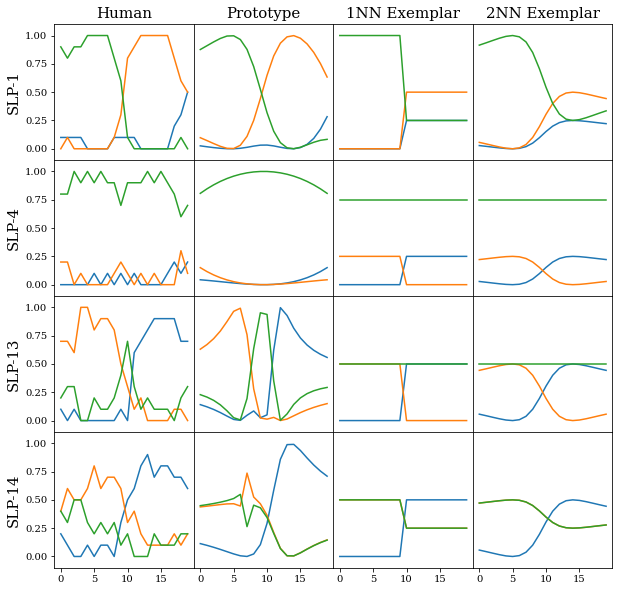

In [23]:
counter=0
fig = plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "Serif"

for num in [1,4,13,14]:
    counter+=1
    ignore = ['w93e05c8', 'w8f3a5e6', 'w72ff099', 'w6189e36', 'w3cbe79c',
           'w86d39ac', 'wfc8e96c', 'wf2fae6e', 'w2c152d2', 'wbfb9c6f',]
           #'wcfe7234', 'wb38724c', 'we815cde', 'wb2873cd', 'wf369503']
    button_response_data = pd.read_csv("{}/html-button-response.csv".format(load_dir))
    responses = button_response_data[(button_response_data.task == 'testing_c1_categorize') | (button_response_data.task == 'testing_c2_categorize')]
    responses = responses[["wid", "task", "response", "target_dino", "label_pair", "manifold_jitter"]]
    for wid in ignore:
        responses = responses[responses.wid != wid]
    responses = responses[responses.label_pair == num]

    responses["response"] = responses["response"].astype('category',copy=False)
    responses["target_dino"] = responses["target_dino"].astype('category',copy=False)

    cloud=responses
    cloud_dict={}
    for i in range(20):
        cloud_dict[i]=[0, 0, 0]
    for i in range(len(cloud.target_dino)):
        cloud_dict[int(list(cloud.target_dino)[i])][list(cloud.response)[i]]+=1
    class1 = [cloud_dict[i][0]/sum(cloud_dict[i]) for i in range(20)]
    class2 = [cloud_dict[i][1]/sum(cloud_dict[i]) for i in range(20)]
    class3 = [cloud_dict[i][2]/sum(cloud_dict[i]) for i in range(20)]
    
    plt.subplot(4,4,(counter-1)*4 + 1)
    plt.ylabel("SLP-{0}".format(num), fontsize=15)
    plt.ylim(-0.1,1.1)
    if counter<4:
        plt.xticks([])
    else:
        plt.xticks([0,5,10,15])
    if counter==1:
        plt.title("Human", fontsize=15)
    plt.plot(list(range(20)),class1, label='c1')
    plt.plot(list(range(20)),class2, label='c2')
    plt.plot(list(range(20)),class3, label='c3')
    #plt.legend()
    #plt.show()
    mp1=np.sum(class1*np.array(range(20)))/np.sum(class1)
    mp2=np.sum(class2*np.array(range(20)))/np.sum(class2)
    mp3=np.sum(class3*np.array(range(20)))/np.sum(class3)
    mean_peaks=np.array([mp1,mp2,mp3])

    def peaks(lab1, lab2):
        diffs = lab2-lab1
        shift=(1-lab2)/diffs
        shift[diffs==0]=-0.5
        return 14+(shift*(14-5))
    shift_peaks=peaks(*sl[num])
    #print(mean_peaks)
    #print(shift_peaks)
    from soft_knn import SoftKNN, softmax
    
    plt.subplot(4,4,(counter-1)*4 + 2)
    plt.ylim(-0.1,1.1)
    plt.yticks([])
    if counter<4:
        plt.xticks([])
    else:
        plt.xticks([0,5,10,15])
    if counter==1:
        plt.title("Prototype", fontsize=15)
    clf=SoftKNN(k=3)
    #prototype_loc = optim_peaks(*sl[num])#peaks_dict[num]#mean_peaks+[20,0,0]#+[-3,-11,-1.01]#+[41/2 - mean_peaks[0]/2,0,0]#mean_peaks+[41/2 - mean_peaks[0]/2,-41/2 + mean_peaks[1]/2,0]#np.array([18,13.7,4.6])
    prototype_loc=peaks_dict[num]
    prototype_lab = np.array([np.array([1., 0., 0.]), np.array([0.,1.,0.]), np.array([0.,0.,1.])])
    clf.fit(prototype_loc, prototype_lab)
    x=np.linspace(0,19, 20)
    preds=clf.probabilities(x)
    print(preds)
    plt.plot(x,preds)
    #plt.show()
    #print(prototype_loc)
    
    plt.subplot(4,4,(counter-1)*4 + 3)
    plt.ylim(-0.1,1.1)
    plt.yticks([])
    if counter<4:
        plt.xticks([])
    else:
        plt.xticks([0,5,10,15])
    if counter==1:
        plt.title("1NN Exemplar", fontsize=15)
    clf2=SoftKNN(k=1)
    clf2.fit([5.0001,14.0001],sl[num])
    x=np.linspace(0,19, 20)
    preds=clf2.probabilities(x)
    plt.plot(x,preds)
    #plt.show()
    #print(prototype_loc)
    
    plt.subplot(4,4,(counter-1)*4 + 4)
    plt.ylim(-0.1,1.1)
    plt.yticks([])
    if counter<4:
        plt.xticks([])
    else:
        plt.xticks([0,5,10,15])
    if counter==1:
        plt.title("2NN Exemplar", fontsize=15)
    clf2=SoftKNN(k=2)
    clf2.fit([5.0001,14.0001],sl[num])
    x=np.linspace(0,19, 20)
    preds=clf2.probabilities(x)
    plt.plot(x,preds)
    #plt.show()
fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig("figs/PvE/pve.png", dpi=300)
#     print(prototype_loc)


The optimal value is tensor(9.2519e-17, dtype=torch.float64, grad_fn=<AddBackward0>)
The optimal x is
[23.00000015] [20.36396114] [4.99999985]
(array([23.00000015]), array([20.36396114]), array([4.99999985]))


/home/is2961/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:2886: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



The optimal value is tensor(0.0106, dtype=torch.float64, grad_fn=<AddBackward0>)
The optimal x is
[14.41357569] [14.17438248] [4.99785742]
(array([14.41357569]), array([14.17438248]), array([4.99785742]))


/tmp/ipykernel_149633/2359914842.py:3: RuntimeWarning: divide by zero encountered in true_divide
  shift=(1-lab2)/diffs
/home/is2961/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:2886: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



The optimal value is tensor(0.0347, dtype=torch.float64, grad_fn=<AddBackward0>)
The optimal x is
[22.04723782] [-3.04723782] [9.5]
(array([22.04723782]), array([-3.04723782]), array([9.5]))


/tmp/ipykernel_149633/2359914842.py:3: RuntimeWarning: divide by zero encountered in true_divide
  shift=(1-lab2)/diffs
/home/is2961/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:2886: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



The optimal value is tensor(0.1823, dtype=torch.float64, grad_fn=<AddBackward0>)
The optimal x is
[14.37211708] [13.63880105] [14.23265144]
(array([14.37211708]), array([13.63880105]), array([14.23265144]))


/home/is2961/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:2886: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



The optimal value is tensor(0.0372, dtype=torch.float64, grad_fn=<AddBackward0>)
The optimal x is
[38.11088953] [28.12499369] [-6.21744005]
(array([38.11088953]), array([28.12499369]), array([-6.21744005]))


/home/is2961/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:2886: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



The optimal value is tensor(0.0524, dtype=torch.float64, grad_fn=<AddBackward0>)
The optimal x is
[17.17656846] [15.70552364] [0.30761606]
(array([17.17656846]), array([15.70552364]), array([0.30761606]))


/home/is2961/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:2886: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



The optimal value is tensor(0.0886, dtype=torch.float64, grad_fn=<AddBackward0>)
The optimal x is
[26.30988222] [-6.65929487] [-0.10672716]
(array([26.30988222]), array([-6.65929487]), array([-0.10672716]))


/tmp/ipykernel_149633/2359914842.py:3: RuntimeWarning: divide by zero encountered in true_divide
  shift=(1-lab2)/diffs
/home/is2961/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:2886: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



The optimal value is tensor(0.0005, dtype=torch.float64, grad_fn=<AddBackward0>)
The optimal x is
[20.29201893] [5.41263832] [4.76190422]
(array([20.29201893]), array([5.41263832]), array([4.76190422]))


/home/is2961/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:2886: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



The optimal value is tensor(0.0578, dtype=torch.float64, grad_fn=<AddBackward0>)
The optimal x is
[14.30332787] [14.3008742] [1.19705898]
(array([14.30332787]), array([14.3008742]), array([1.19705898]))


/tmp/ipykernel_149633/2359914842.py:3: RuntimeWarning: divide by zero encountered in true_divide
  shift=(1-lab2)/diffs
/home/is2961/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:2886: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



The optimal value is tensor(0.0240, dtype=torch.float64, grad_fn=<AddBackward0>)
The optimal x is
[16.46614667] [9.5] [2.53385333]
(array([16.46614667]), array([9.5]), array([2.53385333]))


/tmp/ipykernel_149633/2359914842.py:3: RuntimeWarning: divide by zero encountered in true_divide
  shift=(1-lab2)/diffs
/home/is2961/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:2886: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



The optimal value is tensor(0.0010, dtype=torch.float64, grad_fn=<AddBackward0>)
The optimal x is
[24.64977119] [3.56618512] [6.43409388]
(array([24.64977119]), array([3.56618512]), array([6.43409388]))


/tmp/ipykernel_149633/2359914842.py:3: RuntimeWarning: divide by zero encountered in true_divide
  shift=(1-lab2)/diffs
/home/is2961/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:2886: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



The optimal value is tensor(0.0359, dtype=torch.float64, grad_fn=<AddBackward0>)
The optimal x is
[18.41592012] [0.58407988] [9.5]
(array([18.41592012]), array([0.58407988]), array([9.5]))


/home/is2961/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:2886: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



The optimal value is tensor(1.9367e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
The optimal x is
[20.36400044] [4.99994803] [4.99994803]
(array([20.36400044]), array([4.99994803]), array([4.99994803]))


/tmp/ipykernel_149633/2359914842.py:3: RuntimeWarning: divide by zero encountered in true_divide
  shift=(1-lab2)/diffs
/home/is2961/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:2886: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



The optimal value is tensor(0.1603, dtype=torch.float64, grad_fn=<AddBackward0>)
The optimal x is
[9.5] [17.76660152] [1.23339848]
(array([9.5]), array([17.76660152]), array([1.23339848]))


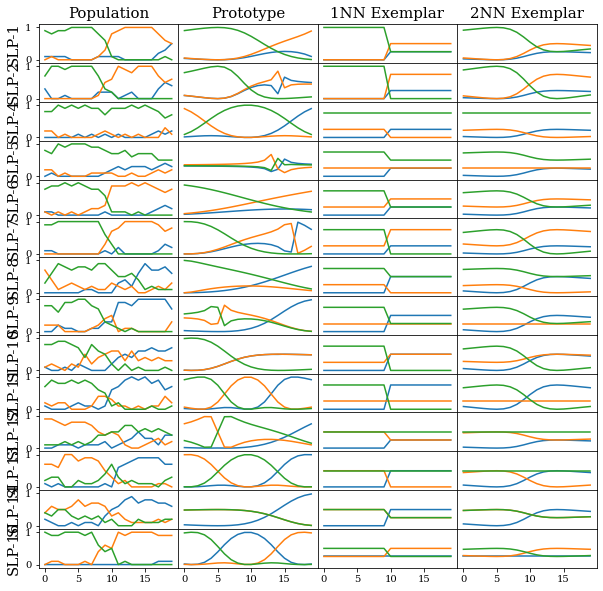

In [78]:
def peaks(lab1, lab2):
    diffs = lab2-lab1
    shift=(1-lab2)/diffs
    shift[diffs==0]=-0.5
    return 14+(shift*(14-5))
shift_peaks=peaks(*sl[num])
#print(mean_peaks)
#print(shift_peaks)
from soft_knn import SoftKNN, softmax
from sklearn.metrics import r2_score as r2
counter=0
fig = plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "Serif"

mses1=[]
mses2=[]
mses3=[]
r2s1=[]
r2s2=[]
r2s3=[]
varis=[]
ignore = ['w93e05c8', 'w8f3a5e6', 'w72ff099', 'w6189e36', 'w3cbe79c',
           'w86d39ac', 'wfc8e96c', 'wf2fae6e', 'w2c152d2', 'wbfb9c6f',]
           #'wcfe7234', 'wb38724c', 'we815cde', 'wb2873cd', 'wf369503']
button_response_data = pd.read_csv("{}/html-button-response.csv".format(load_dir))
responses = button_response_data[(button_response_data.task == 'testing_c1_categorize') | (button_response_data.task == 'testing_c2_categorize')]
responses = responses[["wid", "task", "response", "target_dino", "label_pair", "manifold_jitter"]]
for wid in ignore:
    responses = responses[responses.wid != wid]
num_set=list(set(responses.label_pair))
l=len(num_set)
for num in num_set:
    counter+=1
    ignore = ['w93e05c8', 'w8f3a5e6', 'w72ff099', 'w6189e36', 'w3cbe79c',
           'w86d39ac', 'wfc8e96c', 'wf2fae6e', 'w2c152d2', 'wbfb9c6f',]
           #'wcfe7234', 'wb38724c', 'we815cde', 'wb2873cd', 'wf369503']
    button_response_data = pd.read_csv("{}/html-button-response.csv".format(load_dir))
    responses = button_response_data[(button_response_data.task == 'testing_c1_categorize') | (button_response_data.task == 'testing_c2_categorize')]
    responses = responses[["wid", "task", "response", "target_dino", "label_pair", "manifold_jitter"]]
    for wid in ignore:
        responses = responses[responses.wid != wid]
    responses = responses[responses.label_pair == num]

    responses["response"] = responses["response"].astype('category',copy=False)
    responses["target_dino"] = responses["target_dino"].astype('category',copy=False)

    cloud=responses
    cloud_dict={}
    for i in range(20):
        cloud_dict[i]=[0, 0, 0]
    for i in range(len(cloud.target_dino)):
        cloud_dict[int(list(cloud.target_dino)[i])][list(cloud.response)[i]]+=1
    class1 = [cloud_dict[i][0]/sum(cloud_dict[i]) for i in range(20)]
    class2 = [cloud_dict[i][1]/sum(cloud_dict[i]) for i in range(20)]
    class3 = [cloud_dict[i][2]/sum(cloud_dict[i]) for i in range(20)]
    varis.append(np.var(np.vstack([class1,class2,class3]).transpose()))
    plt.subplot(l,4,(counter-1)*4 + 1)
    plt.ylabel("SLP-{0}".format(num), fontsize=15)
    plt.ylim(-0.1,1.1)
    if counter<l:
        plt.xticks([])
    else:
        plt.xticks([0,5,10,15])
    if counter==1:
        plt.title("Population", fontsize=15)
    plt.plot(list(range(20)),class1, label='c1')
    plt.plot(list(range(20)),class2, label='c2')
    plt.plot(list(range(20)),class3, label='c3')
    #plt.legend()
    #plt.show()
    mp1=np.sum(class1*np.array(range(20)))/np.sum(class1)
    mp2=np.sum(class2*np.array(range(20)))/np.sum(class2)
    mp3=np.sum(class3*np.array(range(20)))/np.sum(class3)
    mean_peaks=np.array([mp1,mp2,mp3])

    
    
    plt.subplot(l,4,(counter-1)*4 + 2)
    plt.ylim(-0.1,1.1)
    plt.yticks([])
    if counter<l:
        plt.xticks([])
    else:
        plt.xticks([0,5,10,15])
    if counter==1:
        plt.title("Prototype", fontsize=15)
    clf=SoftKNN(k=3)
    prototype_loc = optim_peaks(*sl[num])#peaks(*sl[num])+0.001# peaks_dict[num]#mean_peaks+[20,0,0]#+[-3,-11,-1.01]#+[41/2 - mean_peaks[0]/2,0,0]#mean_peaks+[41/2 - mean_peaks[0]/2,-41/2 + mean_peaks[1]/2,0]#np.array([18,13.7,4.6])
    prototype_lab = np.array([np.array([1., 0., 0.]), np.array([0.,1.,0.]), np.array([0.,0.,1.])])
    print(prototype_loc)
    clf.fit(prototype_loc, prototype_lab)
    x=np.linspace(0,19, 20)
    preds=clf.probabilities(x)
    mse1=np.sum((np.vstack([class1, class2, class3]).transpose()-preds)**2)
    mses1.append(mse1)
    r2s1.append(r2(np.vstack([class1, class2, class3]).transpose(),preds,multioutput="variance_weighted"))
    plt.plot(x,preds)
    #plt.show()
    #print(prototype_loc)
    
    plt.subplot(l,4,(counter-1)*4 + 3)
    plt.ylim(-0.1,1.1)
    plt.yticks([])
    if counter<l:
        plt.xticks([])
    else:
        plt.xticks([0,5,10,15])
    if counter==1:
        plt.title("1NN Exemplar", fontsize=15)
    clf2=SoftKNN(k=1)
    clf2.fit([5.0001,14.0001],sl[num])
    x=np.linspace(0,19, 20)
    preds=clf2.probabilities(x)
    mse2=np.sum((np.vstack([class1, class2, class3]).transpose()-preds)**2)
    mses2.append(mse2)
    r2s2.append(r2(np.vstack([class1, class2, class3]).transpose(),preds,multioutput="variance_weighted"))
    plt.plot(x,preds)
    #plt.show()
    #print(prototype_loc)
    
    plt.subplot(l,4,(counter-1)*4 + 4)
    plt.ylim(-0.1,1.1)
    plt.yticks([])
    if counter<l:
        plt.xticks([])
    else:
        plt.xticks([0,5,10,15])
    if counter==1:
        plt.title("2NN Exemplar", fontsize=15)
    clf2=SoftKNN(k=2)
    clf2.fit([5.0001,14.0001],sl[num])
    x=np.linspace(0,19, 20)
    preds=clf2.probabilities(x)
    mse3=np.sum((np.vstack([class1, class2, class3]).transpose()-preds)**2)
    mses3.append(mse3)
    r2s3.append(r2(np.vstack([class1, class2, class3]).transpose(),preds,multioutput="variance_weighted"))
    plt.plot(x,preds)
    #plt.show()
fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig("figs/PvE/pve.png")
#     print(prototype_loc)

In [229]:
from scipy.stats import pearsonr, spearmanr
mses1=np.array(mses1)
mses2=np.array(mses2)
mess3=np.array(mses3)
varis=np.array(varis)
np.mean(mses1),np.mean(mses2), np.mean(mses3)
np.mean(r2s1), np.mean(r2s2), np.mean(r2s3)

(0.6085577493368524, 0.28429114982360604, 0.2985109770658907)

In [220]:
np.var(np.vstack([class1,class2,class3]).transpose())


0.1768888888888889

## Classifications

In [80]:
def hardmax(x):
    preds=x.max(axis=1,keepdims=1) == x
    normed=[p/sum(p) for p in preds]
    return normed


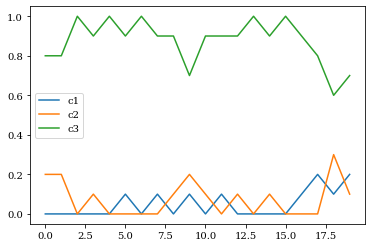

[13.8         9.33333333  9.26857143]
[ 41.  -22.    9.5]


/tmp/ipykernel_132072/576309208.py:38: RuntimeWarning: divide by zero encountered in true_divide
  shift=(1-lab2)/diffs


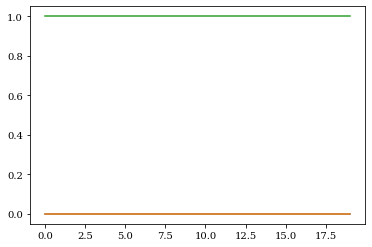

[ 41.  -22.    9.5]


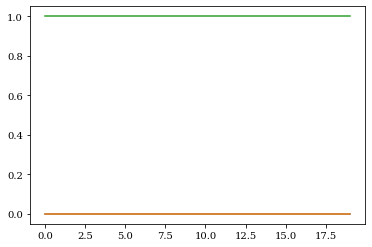

[ 41.  -22.    9.5]


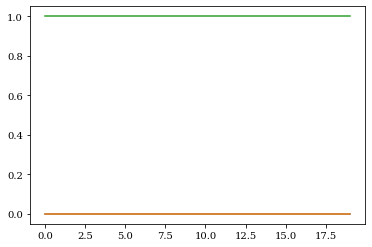

[ 41.  -22.    9.5]


In [15]:
i=0
for num in [4]:
    i+=1
    ignore = ['w93e05c8', 'w8f3a5e6', 'w72ff099', 'w6189e36', 'w3cbe79c',
           'w86d39ac', 'wfc8e96c', 'wf2fae6e', 'w2c152d2', 'wbfb9c6f',]
           #'wcfe7234', 'wb38724c', 'we815cde', 'wb2873cd', 'wf369503']
    button_response_data = pd.read_csv("{}/html-button-response.csv".format(load_dir))
    responses = button_response_data[(button_response_data.task == 'testing_c1_categorize') | (button_response_data.task == 'testing_c2_categorize')]
    responses = responses[["wid", "task", "response", "target_dino", "label_pair", "manifold_jitter"]]
    for wid in ignore:
        responses = responses[responses.wid != wid]
    responses = responses[responses.label_pair == num]

    responses["response"] = responses["response"].astype('category',copy=False)
    responses["target_dino"] = responses["target_dino"].astype('category',copy=False)

    cloud=responses
    cloud_dict={}
    for i in range(20):
        cloud_dict[i]=[0, 0, 0]
    for i in range(len(cloud.target_dino)):
        cloud_dict[int(list(cloud.target_dino)[i])][list(cloud.response)[i]]+=1
    class1 = [cloud_dict[i][0]/sum(cloud_dict[i]) for i in range(20)]
    class2 = [cloud_dict[i][1]/sum(cloud_dict[i]) for i in range(20)]
    class3 = [cloud_dict[i][2]/sum(cloud_dict[i]) for i in range(20)]
    plt.plot(list(range(20)),class1, label='c1')
    plt.plot(list(range(20)),class2, label='c2')
    plt.plot(list(range(20)),class3, label='c3')
    plt.legend()
    plt.show()
    mp1=np.sum(class1*np.array(range(20)))/np.sum(class1)
    mp2=np.sum(class2*np.array(range(20)))/np.sum(class2)
    mp3=np.sum(class3*np.array(range(20)))/np.sum(class3)
    mean_peaks=np.array([mp1,mp2,mp3])

    def peaks(lab1, lab2):
        diffs = lab2-lab1
        shift=(1-lab2)/diffs
        shift[diffs==0]=-0.5
        return 14+(shift*(14-5))
    shift_peaks=peaks(*sl[num])
    print(mean_peaks)
    print(shift_peaks)

    clf=SoftKNN(k=3)
    prototype_loc = shift_peaks#mean_peaks+[20,0,0]#+[-3,-11,-1.01]#+[41/2 - mean_peaks[0]/2,0,0]#mean_peaks+[41/2 - mean_peaks[0]/2,-41/2 + mean_peaks[1]/2,0]#np.array([18,13.7,4.6])
    prototype_lab = np.array([np.array([1., 0., 0.]), np.array([0.,1.,0.]), np.array([0.,0.,1.])])
    clf.fit(prototype_loc, prototype_lab)
    x=np.linspace(0,19, 20)
    preds=clf.probabilities(x)
    preds=hardmax(preds)
    plt.plot(x,preds)
    plt.show()
    print(prototype_loc)

    clf2=SoftKNN(k=1)
    clf2.fit([5.0001,14.0001],sl[num])
    x=np.linspace(0,19, 20)
    preds=clf2.probabilities(x)
    preds=hardmax(preds)
    plt.plot(x,preds)
    plt.show()
    print(prototype_loc)

    clf2=SoftKNN(k=2)
    clf2.fit([5.0001,14.0001],sl[num])
    x=np.linspace(0,19, 20)
    preds=clf2.probabilities(x)
    preds=hardmax(preds)
    plt.plot(x,preds)
    plt.show()
    print(prototype_loc)

/tmp/ipykernel_132072/547007254.py:51: RuntimeWarning: divide by zero encountered in true_divide
  shift=(1-lab2)/diffs
/tmp/ipykernel_132072/547007254.py:51: RuntimeWarning: divide by zero encountered in true_divide
  shift=(1-lab2)/diffs


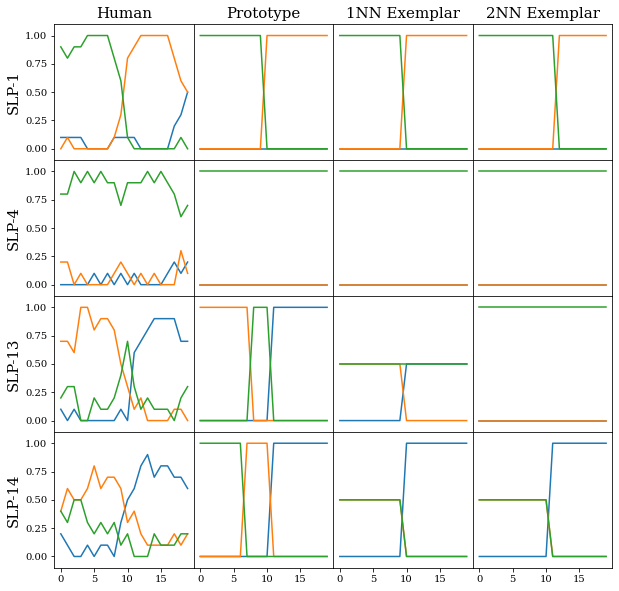

In [16]:
counter=0
fig = plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "Serif"

for num in [1,4,13,14]:
    counter+=1
    ignore = ['w93e05c8', 'w8f3a5e6', 'w72ff099', 'w6189e36', 'w3cbe79c',
           'w86d39ac', 'wfc8e96c', 'wf2fae6e', 'w2c152d2', 'wbfb9c6f',]
           #'wcfe7234', 'wb38724c', 'we815cde', 'wb2873cd', 'wf369503']
    button_response_data = pd.read_csv("{}/html-button-response.csv".format(load_dir))
    responses = button_response_data[(button_response_data.task == 'testing_c1_categorize') | (button_response_data.task == 'testing_c2_categorize')]
    responses = responses[["wid", "task", "response", "target_dino", "label_pair", "manifold_jitter"]]
    for wid in ignore:
        responses = responses[responses.wid != wid]
    responses = responses[responses.label_pair == num]

    responses["response"] = responses["response"].astype('category',copy=False)
    responses["target_dino"] = responses["target_dino"].astype('category',copy=False)

    cloud=responses
    cloud_dict={}
    for i in range(20):
        cloud_dict[i]=[0, 0, 0]
    for i in range(len(cloud.target_dino)):
        cloud_dict[int(list(cloud.target_dino)[i])][list(cloud.response)[i]]+=1
    class1 = [cloud_dict[i][0]/sum(cloud_dict[i]) for i in range(20)]
    class2 = [cloud_dict[i][1]/sum(cloud_dict[i]) for i in range(20)]
    class3 = [cloud_dict[i][2]/sum(cloud_dict[i]) for i in range(20)]
    
    plt.subplot(4,4,(counter-1)*4 + 1)
    plt.ylabel("SLP-{0}".format(num), fontsize=15)
    plt.ylim(-0.1,1.1)
    if counter<4:
        plt.xticks([])
    else:
        plt.xticks([0,5,10,15])
    if counter==1:
        plt.title("Human", fontsize=15)
    plt.plot(list(range(20)),class1, label='c1')
    plt.plot(list(range(20)),class2, label='c2')
    plt.plot(list(range(20)),class3, label='c3')
    #plt.legend()
    #plt.show()
    mp1=np.sum(class1*np.array(range(20)))/np.sum(class1)
    mp2=np.sum(class2*np.array(range(20)))/np.sum(class2)
    mp3=np.sum(class3*np.array(range(20)))/np.sum(class3)
    mean_peaks=np.array([mp1,mp2,mp3])

    def peaks(lab1, lab2):
        diffs = lab2-lab1
        shift=(1-lab2)/diffs
        shift[diffs==0]=-0.5
        return 14+(shift*(14-5))
    shift_peaks=peaks(*sl[num])
    #print(mean_peaks)
    #print(shift_peaks)
    from soft_knn import SoftKNN, softmax
    
    plt.subplot(4,4,(counter-1)*4 + 2)
    plt.ylim(-0.1,1.1)
    plt.yticks([])
    if counter<4:
        plt.xticks([])
    else:
        plt.xticks([0,5,10,15])
    if counter==1:
        plt.title("Prototype", fontsize=15)
    clf=SoftKNN(k=3)
    prototype_loc = peaks_dict[num]#mean_peaks+[20,0,0]#+[-3,-11,-1.01]#+[41/2 - mean_peaks[0]/2,0,0]#mean_peaks+[41/2 - mean_peaks[0]/2,-41/2 + mean_peaks[1]/2,0]#np.array([18,13.7,4.6])
    prototype_lab = np.array([np.array([1., 0., 0.]), np.array([0.,1.,0.]), np.array([0.,0.,1.])])
    clf.fit(prototype_loc, prototype_lab)
    x=np.linspace(0,19, 20)
    preds=clf.probabilities(x)
    #preds=hardmax(preds)
    plt.plot(x,preds)
    #plt.show()
    #print(prototype_loc)
    
    plt.subplot(4,4,(counter-1)*4 + 3)
    plt.ylim(-0.1,1.1)
    plt.yticks([])
    if counter<4:
        plt.xticks([])
    else:
        plt.xticks([0,5,10,15])
    if counter==1:
        plt.title("1NN Exemplar", fontsize=15)
    clf2=SoftKNN(k=1)
    clf2.fit([5.0001,14.0001],sl[num])
    x=np.linspace(0,19, 20)
    preds=clf2.probabilities(x)
    #preds=hardmax(preds)
    plt.plot(x,preds)
    #plt.show()
    #print(prototype_loc)
    
    plt.subplot(4,4,(counter-1)*4 + 4)
    plt.ylim(-0.1,1.1)
    plt.yticks([])
    if counter<4:
        plt.xticks([])
    else:
        plt.xticks([0,5,10,15])
    if counter==1:
        plt.title("2NN Exemplar", fontsize=15)
    clf2=SoftKNN(k=2)
    clf2.fit([5.0001,14.0001],sl[num])
    x=np.linspace(0,19, 20)
    preds=clf2.probabilities(x)
    preds=hardmax(preds)
    plt.plot(x,preds)
    #plt.show()
fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig("figs/PvE/pve.png")
#     print(prototype_loc)

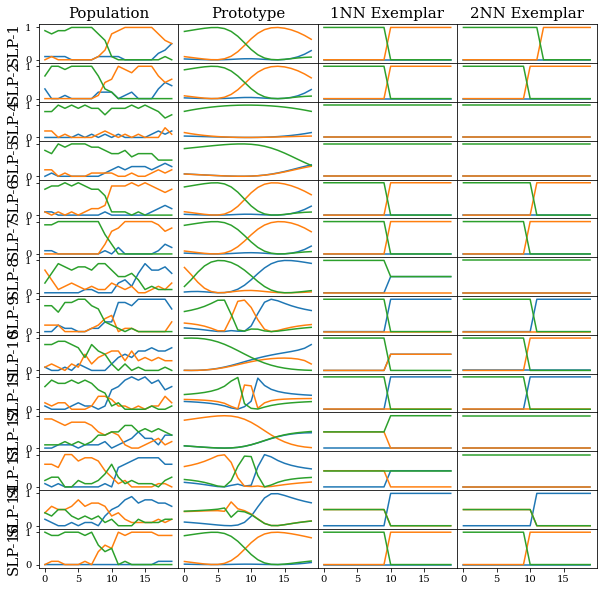

In [81]:
def peaks(lab1, lab2):
    diffs = lab2-lab1
    shift=(1-lab2)/diffs
    shift[diffs==0]=-0.5
    return 14+(shift*(14-5))
shift_peaks=peaks(*sl[num])
#print(mean_peaks)
#print(shift_peaks)
from soft_knn import SoftKNN, softmax
from sklearn.metrics import r2_score as r2
counter=0
fig = plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "Serif"

mses1=[]
mses2=[]
mses3=[]
r2s1=[]
r2s2=[]
r2s3=[]
varis=[]
ignore = ['w93e05c8', 'w8f3a5e6', 'w72ff099', 'w6189e36', 'w3cbe79c',
           'w86d39ac', 'wfc8e96c', 'wf2fae6e', 'w2c152d2', 'wbfb9c6f',]
           #'wcfe7234', 'wb38724c', 'we815cde', 'wb2873cd', 'wf369503']
button_response_data = pd.read_csv("{}/html-button-response.csv".format(load_dir))
responses = button_response_data[(button_response_data.task == 'testing_c1_categorize') | (button_response_data.task == 'testing_c2_categorize')]
responses = responses[["wid", "task", "response", "target_dino", "label_pair", "manifold_jitter"]]
for wid in ignore:
    responses = responses[responses.wid != wid]
num_set=list(set(responses.label_pair))
l=len(num_set)
for num in num_set:
    counter+=1
    ignore = ['w93e05c8', 'w8f3a5e6', 'w72ff099', 'w6189e36', 'w3cbe79c',
           'w86d39ac', 'wfc8e96c', 'wf2fae6e', 'w2c152d2', 'wbfb9c6f',]
           #'wcfe7234', 'wb38724c', 'we815cde', 'wb2873cd', 'wf369503']
    button_response_data = pd.read_csv("{}/html-button-response.csv".format(load_dir))
    responses = button_response_data[(button_response_data.task == 'testing_c1_categorize') | (button_response_data.task == 'testing_c2_categorize')]
    responses = responses[["wid", "task", "response", "target_dino", "label_pair", "manifold_jitter"]]
    for wid in ignore:
        responses = responses[responses.wid != wid]
    responses = responses[responses.label_pair == num]

    responses["response"] = responses["response"].astype('category',copy=False)
    responses["target_dino"] = responses["target_dino"].astype('category',copy=False)

    cloud=responses
    cloud_dict={}
    for i in range(20):
        cloud_dict[i]=[0, 0, 0]
    for i in range(len(cloud.target_dino)):
        cloud_dict[int(list(cloud.target_dino)[i])][list(cloud.response)[i]]+=1
    class1 = [cloud_dict[i][0]/sum(cloud_dict[i]) for i in range(20)]
    class2 = [cloud_dict[i][1]/sum(cloud_dict[i]) for i in range(20)]
    class3 = [cloud_dict[i][2]/sum(cloud_dict[i]) for i in range(20)]
    varis.append(np.var(np.vstack([class1,class2,class3]).transpose()))
    plt.subplot(l,4,(counter-1)*4 + 1)
    plt.ylabel("SLP-{0}".format(num), fontsize=15)
    plt.ylim(-0.1,1.1)
    if counter<l:
        plt.xticks([])
    else:
        plt.xticks([0,5,10,15])
    if counter==1:
        plt.title("Population", fontsize=15)
    plt.plot(list(range(20)),class1, label='c1')
    plt.plot(list(range(20)),class2, label='c2')
    plt.plot(list(range(20)),class3, label='c3')
    #plt.legend()
    #plt.show()
    mp1=np.sum(class1*np.array(range(20)))/np.sum(class1)
    mp2=np.sum(class2*np.array(range(20)))/np.sum(class2)
    mp3=np.sum(class3*np.array(range(20)))/np.sum(class3)
    mean_peaks=np.array([mp1,mp2,mp3])

    
    
    plt.subplot(l,4,(counter-1)*4 + 2)
    plt.ylim(-0.1,1.1)
    plt.yticks([])
    if counter<l:
        plt.xticks([])
    else:
        plt.xticks([0,5,10,15])
    if counter==1:
        plt.title("Prototype", fontsize=15)
    clf=SoftKNN(k=3)
    prototype_loc = peaks_dict[num]#mean_peaks+[20,0,0]#+[-3,-11,-1.01]#+[41/2 - mean_peaks[0]/2,0,0]#mean_peaks+[41/2 - mean_peaks[0]/2,-41/2 + mean_peaks[1]/2,0]#np.array([18,13.7,4.6])
    prototype_lab = np.array([np.array([1., 0., 0.]), np.array([0.,1.,0.]), np.array([0.,0.,1.])])
    clf.fit(prototype_loc, prototype_lab)
    x=np.linspace(0,19, 20)
    preds=clf.probabilities(x)
    #preds=hardmax(preds)
    mse1=np.sum((np.vstack([class1, class2, class3]).transpose()-preds)**2)
    mses1.append(mse1)
    r2s1.append(r2(np.vstack([class1, class2, class3]).transpose(),preds,multioutput="variance_weighted"))
    plt.plot(x,preds)
    #plt.show()
    #print(prototype_loc)
    
    plt.subplot(l,4,(counter-1)*4 + 3)
    plt.ylim(-0.1,1.1)
    plt.yticks([])
    if counter<l:
        plt.xticks([])
    else:
        plt.xticks([0,5,10,15])
    if counter==1:
        plt.title("1NN Exemplar", fontsize=15)
    clf2=SoftKNN(k=1)
    clf2.fit([5.0001,14.0001],sl[num])
    x=np.linspace(0,19, 20)
    preds=clf2.probabilities(x)
    preds=hardmax(preds)
    mse2=np.sum((np.vstack([class1, class2, class3]).transpose()-preds)**2)
    mses2.append(mse2)
    r2s2.append(r2(np.vstack([class1, class2, class3]).transpose(),preds,multioutput="variance_weighted"))
    plt.plot(x,preds)
    #plt.show()
    #print(prototype_loc)
    
    plt.subplot(l,4,(counter-1)*4 + 4)
    plt.ylim(-0.1,1.1)
    plt.yticks([])
    if counter<l:
        plt.xticks([])
    else:
        plt.xticks([0,5,10,15])
    if counter==1:
        plt.title("2NN Exemplar", fontsize=15)
    clf2=SoftKNN(k=2)
    clf2.fit([5.0001,14.0001],sl[num])
    x=np.linspace(0,19, 20)
    preds=clf2.probabilities(x)
    preds=hardmax(preds)
    mse3=np.sum((np.vstack([class1, class2, class3]).transpose()-preds)**2)
    mses3.append(mse3)
    r2s3.append(r2(np.vstack([class1, class2, class3]).transpose(),preds,multioutput="variance_weighted"))
    plt.plot(x,preds)
    #plt.show()
fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig("figs/PvE/pve.png")
#     print(prototype_loc)